In [1]:
import torch
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.cuda.is_available()

True

In [3]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test,y_pred,labels=None,lenth=20,ratio=False,cmap="Blues",annot=True,width=12,fmt="g"):
    if labels == None:
        labels = pd.Series(labels for labels in y_test.squeeze()).unique()
    conf_mat = pd.DataFrame(confusion_matrix(y_test.squeeze(), y_pred.squeeze(), labels=labels))
    if ratio == True:
        conf_mat = conf_mat.divide(conf_mat.sum(axis=1), axis=0)
    fig, ax = plt.subplots(figsize=(lenth, width))
    sns.heatmap(conf_mat,cmap=cmap,annot=annot,xticklabels=labels,yticklabels=labels,fmt=fmt)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

In [4]:
f = open('word2idx.pkl','rb')
word2idx = pickle.load(f)
f.close()
f = open('idx2word.pkl','rb')
idx2word= pickle.load(f)
f.close()
f = open('word_df.pkl','rb')
word_df= pickle.load(f)
f.close()
f = open('word_embedding.pkl','rb')
word_embedding= pickle.load(f)
f.close()

In [5]:
EOS_NUM = 0
UNK_NUM = 1
PADDLING_NUM = 2

In [6]:
word_df['text'].apply(len).describe()

count    56821.000000
mean         9.087344
std          2.868494
min          0.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         48.000000
Name: text, dtype: float64

In [7]:
word_df['text'].apply(len).describe()

count    56821.000000
mean         9.087344
std          2.868494
min          0.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         48.000000
Name: text, dtype: float64

In [8]:
len(word_embedding)

35042

In [9]:
def getWordEmbedding(data):
    seq_embed = []
    _ = 0
    for word in data:
        seq_embed.append(word_embedding[word])
        _ += 1
        if _ == 9:
            break
    if _ <= 9:
        for i in range(9 - _):
            seq_embed.append(np.zeros(256))
    seq_embed = np.array(seq_embed)
    return seq_embed

In [10]:
# def getWordEmbedding(data):
#     seq_embed = []
#     _ = 0
#     for word in data:
#         seq_embed.append(word)
#         _ += 1
#         if _ == 9:
#             break
#     if _ <= 9:
#         for i in range(9 - _):
#             seq_embed.append()
#     seq_embed = np.array(seq_embed)
#     return seq_embed

In [11]:
word_df['text'] = word_df['text'].apply(getWordEmbedding)

In [12]:
train_df = word_df[['text','class']]
train_df['class'] = train_df['class'].apply(np.float32)

C:\Users\Javon\AppData\Local\Temp/ipykernel_9420/72822735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class'] = train_df['class'].apply(np.float32)


In [13]:
train_df['text'][0]

array([[-0.16856599,  0.23337452,  0.11142877, ..., -0.12394199,
         0.2109255 , -0.26906604],
       [-0.3324016 ,  0.2831528 ,  0.12413874, ..., -0.03661533,
         0.2083672 , -0.26072726],
       [-0.2894354 ,  0.17579173,  0.42679918, ..., -0.2663124 ,
         0.3230005 , -0.12830356],
       ...,
       [-0.20966044,  0.09183218,  0.06343362, ..., -0.17449388,
         0.12152474, -0.29336753],
       [-0.15585347,  0.19525446,  0.0944691 , ..., -0.15241647,
         0.18608207, -0.2801387 ],
       [-0.14757705,  0.25896308,  0.08283925, ..., -0.30095196,
         0.22226642, -0.31638423]], dtype=float32)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(
    train_df['text'].values,
    train_df['class'].values,
    test_size=0.2,
    stratify=train_df['class'],
    random_state=42,
)

In [15]:
class seqDataset(torch.utils.data.Dataset):
    def __init__(self,data,label,transformer = None):
        super(seqDataset,self).__init__()
        self.data = data
        self.label = label
        self.transformer = transformer
    
    def __getitem__(self,idx):
        if self.transformer:
            return transformer(self.data[idx]),self.label[idx]
        return self.data[idx],self.label[idx]
    
    def __len__(self):
        return len(self.data)

In [16]:
X_train[0]

array([[-1.6792463e-01,  8.1367984e-02,  8.8820286e-02, ...,
        -1.7098169e-01,  1.5930666e-01, -2.8925949e-01],
       [-1.4969066e-01,  2.5004625e-01,  9.2446432e-02, ...,
        -1.2358303e-01,  1.8865260e-01, -3.1199834e-01],
       [ 1.9570090e-05,  2.1952850e-05, -8.4800395e-06, ...,
        -2.5540157e-06, -2.5010400e-05,  9.2919963e-06],
       ...,
       [-2.8943539e-01,  1.7579173e-01,  4.2679918e-01, ...,
        -2.6631239e-01,  3.2300049e-01, -1.2830356e-01],
       [-4.1714215e-01,  3.0464903e-01,  3.7976551e-01, ...,
         5.7909604e-02,  2.9920489e-01, -3.9727098e-01],
       [-1.7251106e-01,  1.3417794e-01,  9.7718470e-02, ...,
        -1.7982249e-01,  1.8398903e-01, -2.5653276e-01]], dtype=float32)

In [17]:
X_train = np.array([np.array([np.array(__) for __ in _]) for _ in X_train])
X_test = np.array([np.array([np.array(__) for __ in _]) for _ in X_test])

In [18]:
train_dataset = seqDataset(X_train,y_train)
test_dataset = seqDataset(X_test,y_test)

In [19]:
train_dataset[0][0].shape

(9, 256)

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=500)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=500)

In [21]:
for i,(x,y) in enumerate(train_loader):
    print(x.shape)
    break

torch.Size([500, 9, 256])


In [22]:
def train(model,EPOCH=150,learning_rate=0.05):
    model = model
    opt = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    EPOCH = EPOCH
    itr = 0
    model.cuda()
    for epoch in range(EPOCH):
        for i,(x,y) in enumerate(train_loader):
            batch_X = torch.FloatTensor(np.float32(x)).cuda()
            batch_Y = torch.LongTensor(np.int64(y)).cuda()
            output = model(batch_X)
            opt.zero_grad()
            loss = loss_fn(output,batch_Y)
            loss.backward()
            opt.step()
            if (i+1) % 20 == 0:
                itr += 20
                acc = (batch_Y.detach().cpu().numpy() == output.detach().cpu().argmax(axis=1).numpy()).mean()
                print('epoch\t:{}\titr:{}\tloss:{}\tacc:{}\n'.format(epoch,itr,loss,acc))
                # print(output.detach().cpu())
    return model

def test(model):
    accs = []
    y_pred = []
    y_true = []
    for i,(x,y) in enumerate(test_loader):
        batch_X = torch.FloatTensor(np.float32(x)).cuda()
        batch_Y = torch.LongTensor(np.int64(y)).cuda()
        output = model(batch_X)
        acc = (batch_Y.detach().cpu().numpy() == output.detach().cpu().argmax(axis=1).numpy()).mean()
        accs.append(acc)
        y_pred.extend(output.detach().cpu().argmax(axis=1).numpy())
        y_true.extend(batch_Y.detach().cpu().numpy()) 
    print(np.array(accs).mean())
    return y_pred,y_true

In [23]:
class SimpleRNN(nn.Module):
    def __init__(self,seq_len=9,embedding_size=256,h1_size=128,num_embeddings = len(idx2word)):
        super(SimpleRNN,self).__init__()
        self.embedding_size = embedding_size
        self.h1_size = h1_size
        self.seq_len = seq_len
        self.num_embeddings = num_embeddings

        self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)

        self.layer1 = nn.Sequential(
            nn.RNN(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=4,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.embed(x)
        out,hid = self.layer1(x)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [32]:
class SimpleLSTM(nn.Module):
    def __init__(self,seq_len=9,embedding_size=256,h1_size=128,num_embeddings = len(idx2word)):
        super(SimpleLSTM,self).__init__()
        self.embedding_size = embedding_size
        self.h1_size = h1_size
        self.seq_len = seq_len
        self.num_embeddings = num_embeddings

        self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)

        self.layer1 = nn.Sequential(
            nn.LSTM(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=4,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.embed(x)
        out,(hn, cn) = self.layer1(x)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [25]:
class TransformerEncoder(nn.Module):
    def __init__(self,seq_len=9,embedding_size=256,num_embeddings = len(idx2word)):
        super(TransformerEncoder,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.seq_len*self.embedding_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        out = self.output(out)
        return out

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self,embedding_size=256,num_embeddings = len(idx2word)):
        super(SimpleCNN,self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size
        # self.embed = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels = 256,out_channels = 256,kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
        )
        #[batch_size = 500,channels=128,seq_len - k_s + 1 = 8]
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels = 256,out_channels = 256,kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
        )
        #[batch_size = 500,embedding_size = 128,seq_len - k_s + 1 = 7]
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels = 256,out_channels = 256,kernel_size=3,stride = 2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            # nn.MaxPool1d(6),
        )
        #[batch_size = 500,embedding_size = 256,(seq_len - k_s)/2+ 1 = 3]
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels = 256,out_channels = 128,kernel_size = 3),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )
        #[batch_size = 500,embedding_size = 256,seq_len - k_s + 1 = 1]


        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128,10),
            nn.Softmax()
        )
    def forward(self,x):
        # out = self.embed(x).transpose(2,1)
        out = self.conv1(x.transpose(2,1))
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.output(out)
        return out

In [27]:
class TransformerLSTM(nn.Module):
    def __init__(self,seq_len=9,embedding_size=256,num_embeddings = len(idx2word),h1_size = 100):
        super(TransformerLSTM,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.h1_size = h1_size
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
        )
        self.layer2 = nn.Sequential(
            nn.LSTM(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=2,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        out,hid = self.layer2(out)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [28]:
class TransformerRNN(nn.Module):
    def __init__(self,seq_len=9,embedding_size=256,num_embeddings = len(idx2word),h1_size = 100):
        super(TransformerRNN,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.h1_size = h1_size
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
        )
        self.layer2 = nn.Sequential(
            nn.RNN(input_size = self.embedding_size,hidden_size = self.h1_size,num_layers=2,batch_first=True),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.h1_size,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        out,hid = self.layer2(out)
        out = out[:,-1,:]
        out = self.output(out)
        return out

In [29]:
class TransformerCNN(nn.Module):
    def __init__(self,seq_len=9,embedding_size=256,num_embeddings = len(idx2word),h1_size = 100):
        super(TransformerCNN,self).__init__()
        self.num_embeddings = num_embeddings 
        self.embedding_size = embedding_size
        self.seq_len = seq_len
        self.h1_size = h1_size
        self.emb = nn.Embedding(num_embeddings=self.num_embeddings,embedding_dim=self.embedding_size)
        self.layer1 = nn.Sequential(
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
            nn.TransformerEncoderLayer(d_model=embedding_size, nhead=8, batch_first=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = 256,out_channels = 128,kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )

        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = 128,out_channels = 128,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )

        self.layer4 = nn.Sequential(
            nn.Conv1d(in_channels = 128,out_channels = 128,kernel_size=4),
            nn.ReLU(),
            nn.BatchNorm1d(128),
        )

        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128,10),
            nn.Softmax(),
        )
    def forward(self,x):
        # out = self.emb(x)
        out = self.layer1(x)
        out = self.layer2(out.transpose(2,1))
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.output(out)
        return out

In [ ]:
model = train(SimpleCNN(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

In [ ]:
model = train(TransformerLSTM(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

In [ ]:
model = train(TransformerRNN(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

In [ ]:
model = train(TransformerCNN(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

In [35]:
model = train(SimpleRNN(),EPOCH=800,learning_rate=1)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.2838985919952393	acc:0.138

epoch	:0	itr:40	loss:2.2834818363189697	acc:0.14

epoch	:0	itr:60	loss:2.274735927581787	acc:0.148

epoch	:0	itr:80	loss:2.27032470703125	acc:0.166

epoch	:1	itr:100	loss:2.2734711170196533	acc:0.138

epoch	:1	itr:120	loss:2.2824506759643555	acc:0.14

epoch	:1	itr:140	loss:2.2738637924194336	acc:0.152

epoch	:1	itr:160	loss:2.268317937850952	acc:0.166

epoch	:2	itr:180	loss:2.272843837738037	acc:0.138

epoch	:2	itr:200	loss:2.2826035022735596	acc:0.142

epoch	:2	itr:220	loss:2.2708206176757812	acc:0.158

epoch	:2	itr:240	loss:2.2685723304748535	acc:0.158

epoch	:3	itr:260	loss:2.2664546966552734	acc:0.18

epoch	:3	itr:280	loss:2.271852731704712	acc:0.168

epoch	:3	itr:300	loss:2.264335870742798	acc:0.182

epoch	:3	itr:320	loss:2.2498252391815186	acc:0.194

epoch	:4	itr:340	loss:2.2603073120117188	acc:0.17

epoch	:4	itr:360	loss:2.262279510498047	acc:0.184

epoch	:4	itr:380	loss:2.2621095180511475	acc:0.184

epoch	:4	itr:400	loss:2.2455

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.301731586456299	acc:0.138

epoch	:0	itr:40	loss:2.3008248805999756	acc:0.14

epoch	:0	itr:60	loss:2.299470901489258	acc:0.134

epoch	:0	itr:80	loss:2.2973926067352295	acc:0.166

epoch	:1	itr:100	loss:2.2963924407958984	acc:0.138

epoch	:1	itr:120	loss:2.2965683937072754	acc:0.14

epoch	:1	itr:140	loss:2.2944014072418213	acc:0.134

epoch	:1	itr:160	loss:2.2912402153015137	acc:0.166

epoch	:2	itr:180	loss:2.291036367416382	acc:0.138

epoch	:2	itr:200	loss:2.292314291000366	acc:0.14

epoch	:2	itr:220	loss:2.289395570755005	acc:0.134

epoch	:2	itr:240	loss:2.2846598625183105	acc:0.166

epoch	:3	itr:260	loss:2.2859811782836914	acc:0.138

epoch	:3	itr:280	loss:2.28853440284729	acc:0.14

epoch	:3	itr:300	loss:2.2851061820983887	acc:0.134

epoch	:3	itr:320	loss:2.2789101600646973	acc:0.166

epoch	:4	itr:340	loss:2.2821712493896484	acc:0.138

epoch	:4	itr:360	loss:2.286132335662842	acc:0.14

epoch	:4	itr:380	loss:2.281914472579956	acc:0.134

epoch	:4	itr:400	loss:2.275580

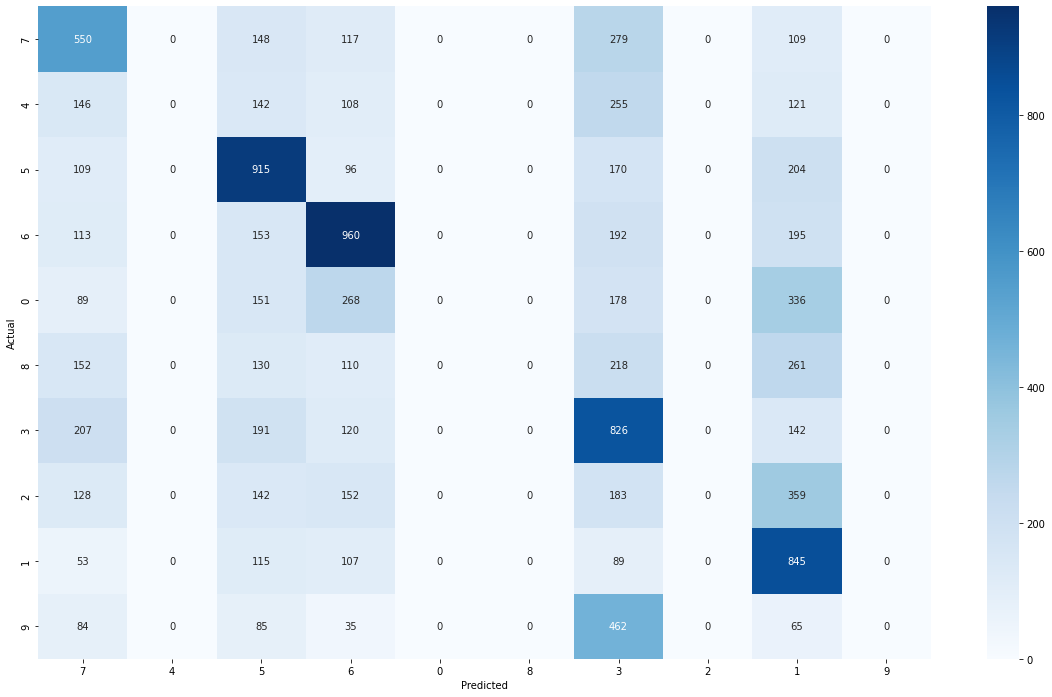

In [ ]:
model = train(SimpleLSTM(),EPOCH=800,learning_rate=1)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))

D:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch	:0	itr:20	loss:2.323153495788574	acc:0.138

epoch	:0	itr:40	loss:2.321150541305542	acc:0.14

epoch	:0	itr:60	loss:2.3271498680114746	acc:0.134

epoch	:0	itr:80	loss:2.2951500415802	acc:0.166

epoch	:1	itr:100	loss:2.323150396347046	acc:0.138

epoch	:1	itr:120	loss:2.3211498260498047	acc:0.14

epoch	:1	itr:140	loss:2.3271498680114746	acc:0.134

epoch	:1	itr:160	loss:2.2951500415802	acc:0.166

epoch	:2	itr:180	loss:2.323150157928467	acc:0.138

epoch	:2	itr:200	loss:2.3211498260498047	acc:0.14

epoch	:2	itr:220	loss:2.3271498680114746	acc:0.134

epoch	:2	itr:240	loss:2.2951500415802	acc:0.166

epoch	:3	itr:260	loss:2.323150157928467	acc:0.138

epoch	:3	itr:280	loss:2.3211498260498047	acc:0.14

epoch	:3	itr:300	loss:2.3271498680114746	acc:0.134

epoch	:3	itr:320	loss:2.2951500415802	acc:0.166

epoch	:4	itr:340	loss:2.323150157928467	acc:0.138

epoch	:4	itr:360	loss:2.3211498260498047	acc:0.14

epoch	:4	itr:380	loss:2.3271498680114746	acc:0.134

epoch	:4	itr:400	loss:2.2951500415802	a

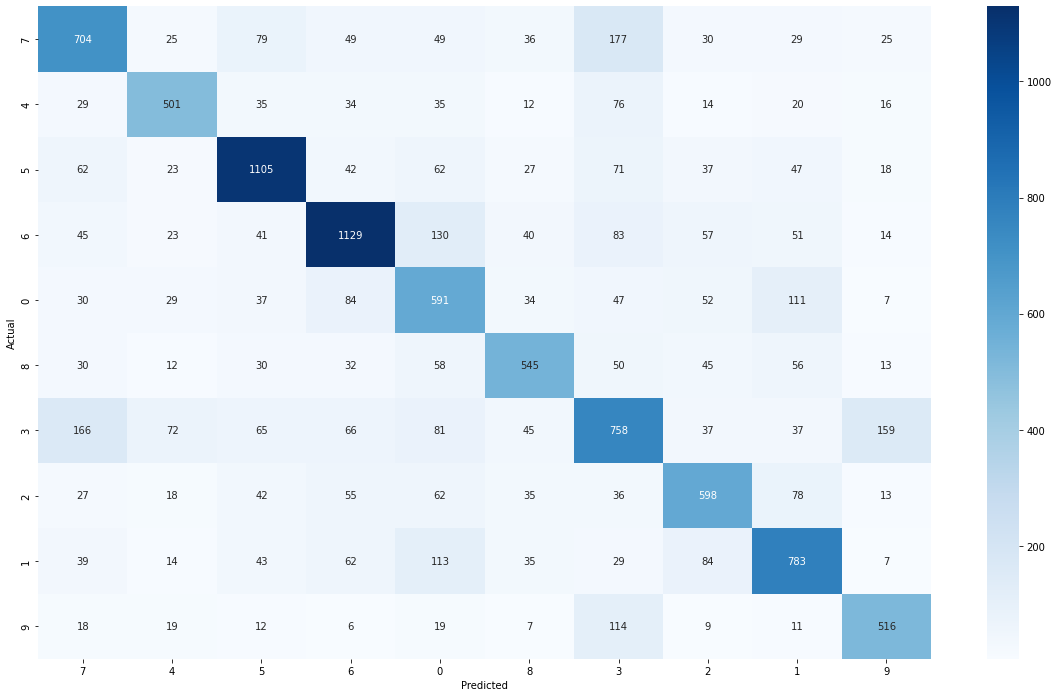

In [34]:
model = train(TransformerEncoder(),EPOCH=500,learning_rate=0.5)
y_pred,y_true = test(model)
plot_confusion_matrix(np.array(y_true),np.array(y_pred))